Integrantes: Gabriel Oliveira ; Leopoldo Nunes ; Matheus Aguiar
# AcadMatch: Sistema Inteligente de Busca e Afinidade Acadêmica
### Objetivo:
O objetivo central do projeto foi o desenvolvimento de um sistema de busca acadêmica inteligente, capaz de identificar professores cujo perfil de pesquisa apresenta maior afinidade semântica com um projeto proposto. Para isso, foram utilizadas técnicas de processamento de linguagem natural, aprendizado de máquina não supervisionado e medidas de similaridade, permitindo a análise e comparação de produções científicas de forma automatizada. O sistema visa apoiar processos de orientação, colaboração científica e formação de equipes acadêmicas, promovendo a aproximação entre projetos e especialistas com maior compatibilidade temática.

In [8]:
import kagglehub
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

In [9]:
path = kagglehub.dataset_download(
    "sumitm004/arxiv-scientific-research-papers-dataset"
)

file = os.listdir(path)[0]
df = pd.read_csv(os.path.join(path, file))

df = df[["title", "summary", "first_author"]].dropna()
df["texto"] = df["title"] + ". " + df["summary"]

def preprocess(texto):
    texto = texto.lower()
    texto = re.sub(r"http\S+", "", texto)
    texto = re.sub(r"[^a-zà-ÿ\s]", "", texto)
    texto = re.sub(r"\s+", " ", texto)
    return texto.strip()

In [10]:
artigos = []

for _, row in df.iterrows():
    for autor in row["first_author"].split(","):
        artigos.append({
            "autor": autor.strip(),
            "texto": preprocess(row["texto"])
        })

artigos = artigos[:5000]
texts = [a["texto"] for a in artigos]


In [12]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

embeddings = model.encode(
    texts,
    show_progress_bar=True
)


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 929.16it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 157/157 [02:16<00:00,  1.15it/s]


In [13]:
autor_to_vecs = defaultdict(list)

for art, emb in zip(artigos, embeddings):
    autor_to_vecs[art["autor"]].append(emb)

autores = []
X = []

for autor, vecs in autor_to_vecs.items():
    autores.append(autor)
    X.append(np.mean(vecs, axis=0))

X = np.array(X)


In [14]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)


In [15]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_norm)


In [16]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42
)

X_tsne = tsne.fit_transform(X_norm)


In [17]:
df_autores = pd.DataFrame({
    "autor": autores,
    "cluster": labels,
    "x": X_tsne[:, 0],
    "y": X_tsne[:, 1]
})


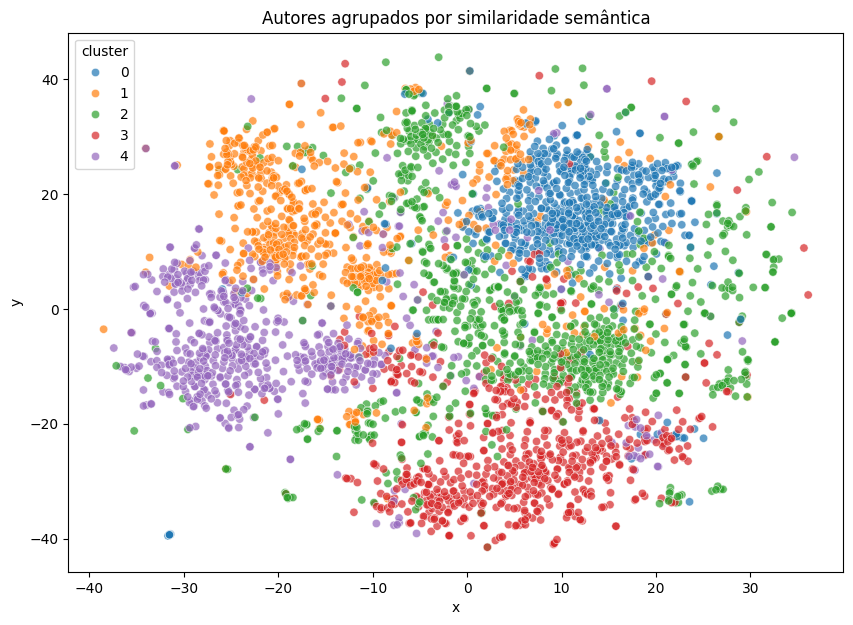

In [18]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_autores,
    x="x",
    y="y",
    hue="cluster",
    palette="tab10",
    alpha=0.7
)

plt.title("Autores agrupados por similaridade semântica")
plt.show()


In [ ]:
descricao_projeto = """
-- Escreve algo, to com sono
"""

v_proj = model.encode(preprocess(descricao_projeto))
v_proj = scaler.transform([v_proj])

In [ ]:
cluster_proj = kmeans.predict(v_proj)[0]

In [ ]:
candidatos = df_autores[df_autores["cluster"] == cluster_proj]

vetores_cluster = X_norm[candidatos.index]
sims = cosine_similarity(v_proj, vetores_cluster)[0]

candidatos = candidatos.copy()
candidatos["similaridade"] = sims

recomendacoes = (
    candidatos
    .sort_values("similaridade", ascending=False)
    [["autor", "similaridade"]]
    .head(10)
)

print("\nAutores recomendados:")
print(recomendacoes)